# NASA SPACE APPS 2024: SEISMIC DETECTION ACROSS THE SOLAR SYSTEM #

## INSTALLING AND IMPORTING NECESSARY PACKAGES: ##

In [1]:
# ! pip install numpy==1.26.4
# ! pip install obspy
# ! pip install emd==0.7.0
# ! pip install tqdm==4.66.4
# ! pip install scikit-learn
# # The torch version depends on the cuda version
# ! pip install torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
# ! pip install ipywidgets==8.1.3
# ! pip install notebook
# ! pip install streamlit
# ! pip install torchinfo

In [2]:
import numpy as np
import obspy
import emd
import pandas as pd
from tqdm.notebook import tqdm
import os
import scipy.signal as sg
from concurrent.futures import ThreadPoolExecutor
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
from torchinfo import summary

In [3]:
# About cuda:

print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("Device Count: ", torch.cuda.device_count())

CUDA Available:  True
CUDA Version:  12.4
Device Count:  1


## GENERAL FUNCTIONS(NOT SPECIFIC TO MARS OR MOON) AND MODEL ##

In [4]:
import torch

# Import necessary libraries
import torch.nn as nn

# Define a convolutional block with batch normalization and ReLU activation
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()
        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        return out       

# Define a squeeze-and-excitation block
class se_block(nn.Module):
    def __init__(self, in_layer, out_layer):
        super(se_block, self).__init__()
        self.conv1 = nn.Conv1d(in_layer, out_layer // 8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer // 8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1, out_layer // 8)
        self.fc2 = nn.Linear(out_layer // 8, out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x_se = nn.functional.adaptive_avg_pool1d(x, 1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        x_out = torch.add(x, x_se)
        return x_out

# Define a residual block with convolutional and squeeze-and-excitation blocks
class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        self.cbr1 = conbr_block(in_layer, out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer, out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self, x):
        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

# Define the UNET model
class UNET(nn.Module):
    def __init__(self, input_dim, layer_n, kernel_size, depth):
        super(UNET, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        # Define average pooling layers
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)
        
        # Define downsampling layers
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size, 1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n * 2), self.kernel_size, 5, 2)
        self.layer3 = self.down_layer(int(self.layer_n * 2) + int(self.input_dim), int(self.layer_n * 3), self.kernel_size, 5, 2)
        self.layer4 = self.down_layer(int(self.layer_n * 3) + int(self.input_dim), int(self.layer_n * 4), self.kernel_size, 5, 2)
        self.layer5 = self.down_layer(int(self.layer_n * 4) + int(self.input_dim), int(self.layer_n * 5), self.kernel_size, 4, 2)

        # Define upsampling layers
        self.cbr_up1 = conbr_block(int(self.layer_n * 7), int(self.layer_n * 3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n * 5), int(self.layer_n * 2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n * 3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        # Define output convolutional layer
        self.outcov = nn.Conv1d(self.layer_n, 1, kernel_size=self.kernel_size, stride=1, padding=3)
    
    # Define a method to create downsampling layers
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer, out_layer, kernel, 1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        # Apply average pooling
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        # Encoder
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        # Concatenate pooled and encoded features
        x = torch.cat([out_1, pool_x1], 1)
        out_2 = self.layer3(x)

        x = torch.cat([out_2, pool_x2], 1)
        x = self.layer4(x)
        
        # Decoder
        up = self.upsample1(x)
        up = torch.cat([up, out_2], 1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up, out_1], 1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up, out_0], 1)
        up = self.cbr_up3(up)
        
        # Output layer
        out = self.outcov(up)
        
        # Apply softmax (commented out)
        # out = nn.functional.softmax(out, dim=2)
        
        return out


In [5]:
# Band-pass filter function using Butterworth filter design.
# Filters the data between lowcut and highcut frequencies.
def butter_bandpass_filter(data: np.array, lowcut: float, highcut: float, fs: float, order: int):
    nyquist = 0.5 * fs  # Nyquist frequency, half of the sampling rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sg.butter(order, [low, high], btype='band', analog=False)  # Design Butterworth band-pass filter
    y = sg.filtfilt(b, a, data)  # Apply filter to data using zero-phase filtering
    return y

## LUNAR AND MARS DATA PREPROCESSING ##

### LUNAR ###

  0%|          | 0/63 [00:00<?, ?it/s]

skip


  0%|          | 0/13 [00:00<?, ?it/s]

(4000, 5)


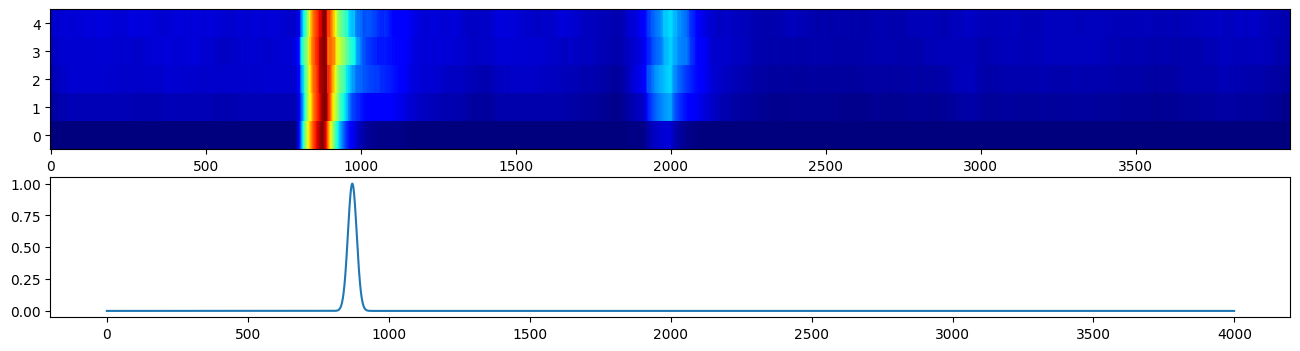

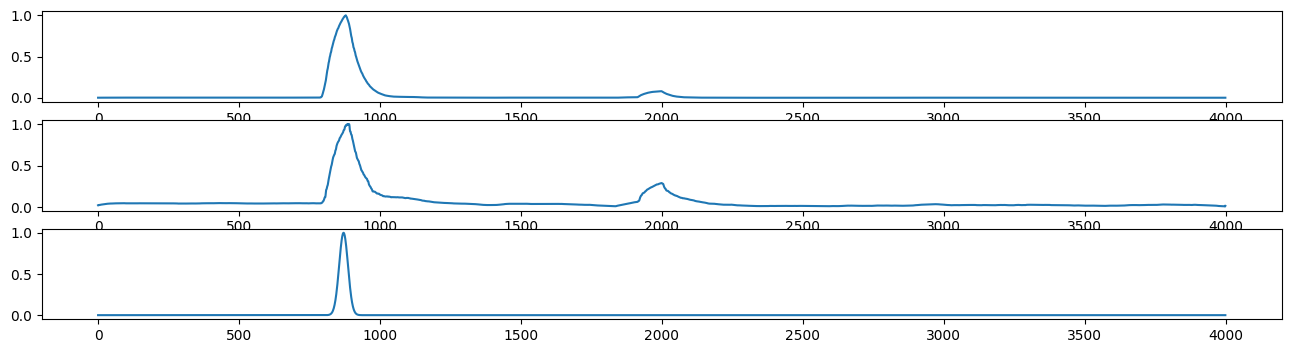

In [6]:
# Define base directory for data.
base_dir = 'data/lunar/training'

# Construct paths in a cross-platform way, compatible with Windows and Linux.
catalogy_path = os.path.join(base_dir, 'catalogs', 'apollo12_catalog_GradeA_final.csv')
data_folder = os.path.join(base_dir, 'data', 'S12_GradeA')

# Read the catalog file which contains metadata about the dataset (e.g., file names, labels, etc.).
# catalogy holds the times of the seismic events.
# Each line of catalogy has a filename that has velocity by time, and where the seismic event is in the sequence.
catalogy = pd.read_csv(catalogy_path)
indexs = catalogy.index  # Get the indices of the catalog entries

# Initialize dictionaries to hold training and validation data.
training_data = {
    'data':[],
    'label':[]
}

validation_data = {
    'data':[],
    'label':[]
}

# Function to process each file based on the index from the catalog.
# Returns a tuple of (input, output) where input is the processed data and output is the label.
def process_file_moon(idx):
    fileName = catalogy.at[idx, 'filename'] + '.mseed'
    arrival_time = catalogy.at[idx, 'time_rel(sec)']

    # Check if the file exists, if not return None.
    if not os.path.exists(os.path.join(data_folder, fileName)):
        return None, None

    # Read the seismic data file and preprocess it.
    stream = obspy.read(os.path.join(data_folder, fileName))
    data = stream[0].data
    time = stream[0].times()
    fs = stream[0].stats.sampling_rate

    # Find the index of the arrival time in the data.
    arrival_idx = np.where(time >= arrival_time)[0][0]

    # Define the window size for the data segment.
    window_size_sec = 30 * 60
    window_size = int(window_size_sec * fs)

    # Apply a bandpass filter to the data.
    data = butter_bandpass_filter(data, 0.4, 1, fs, 6)

    # Perform Empirical Mode Decomposition (EMD) on the data.
    imfs = emd.sift.ensemble_sift(data, max_imfs=5)
    stride = window_size // 48
    input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride, :, :]
    input = np.sum(input, axis=-1)

    # Initialize the output array.
    output = np.zeros((data.shape[0], ))

    # Define the Gaussian window for the output label.
    arrival_idx = np.where(time - window_size_sec / 4 >= arrival_time)[0][0]
    sigma = window_size / 8 * 1.5
    gaussian_window_size = int(window_size * 1.5)
    if gaussian_window_size % 2 == 1: gaussian_window_size += 1
    gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)
    left_idx = arrival_idx - (gaussian_window_size // 2)
    right_idx = arrival_idx + (gaussian_window_size // 2)

    # Adjust indices to fit within the bounds of the output array.
    if left_idx < 0:
        left_idx = 0
    if right_idx > len(output):
        right_idx = len(output)

    # Assign the Gaussian window to the output array.
    output[left_idx:right_idx] = gaussian_window[:right_idx - left_idx]

    # Resample the input and output to a fixed size.
    input = sg.resample(input, 4000, axis=0)
    output = sg.resample(output, 4000)

    # Normalize the input data.
    input_maxs = np.max(input, axis=0)
    input = input / input_maxs

    # Ensure the input has at least 5 channels.
    while input.shape[1] < 5:
        input = np.concatenate([input, np.zeros((input.shape[0], 1)) + 0.001], axis=1)

    return input, output

# Define indices for validation and training sets.
indexs_validation = [7, 8, 22, 23, 27, 34, 36, 37, 40, 48, 49, 67, 68]
indexs_train = [i for i in indexs if i not in indexs_validation]

# Process the training files in parallel using multiple threads.
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    results = list(tqdm(executor.map(process_file_moon, indexs_train), total=len(indexs_train)))

# Collect the processed training data.
for r in results:
    if r[0] is None:
        print('skip')
        continue
    training_data['data'].append(r[0])
    training_data['label'].append(r[1])

# Process the validation files in parallel using multiple threads.
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    results = list(tqdm(executor.map(process_file_moon, indexs_validation), total=len(indexs_validation)))

# Collect the processed validation data.
for r in results:
    if r[0] is None:
        print('skip')
        continue
    validation_data['data'].append(r[0])
    validation_data['label'].append(r[1])

# Display the shape of the first processed input.
inp, out = results[0]
print(inp.shape)

# Plot the first processed input and output.
fig, axs = plt.subplots(2, 1, figsize=(16, 4))
axs[0].imshow(inp.T, aspect='auto', cmap='jet', interpolation='nearest', origin='lower')
axs[1].plot(out)

# Plot individual channels of the first processed input and the output.
fig, axs = plt.subplots(3, 1, figsize=(16, 4))
axs[0].plot(inp[:, 0])
axs[1].plot(inp[:, 1])
axs[2].plot(out)

### MARS ###

  0%|          | 0/2 [00:00<?, ?it/s]

(4000, 5)


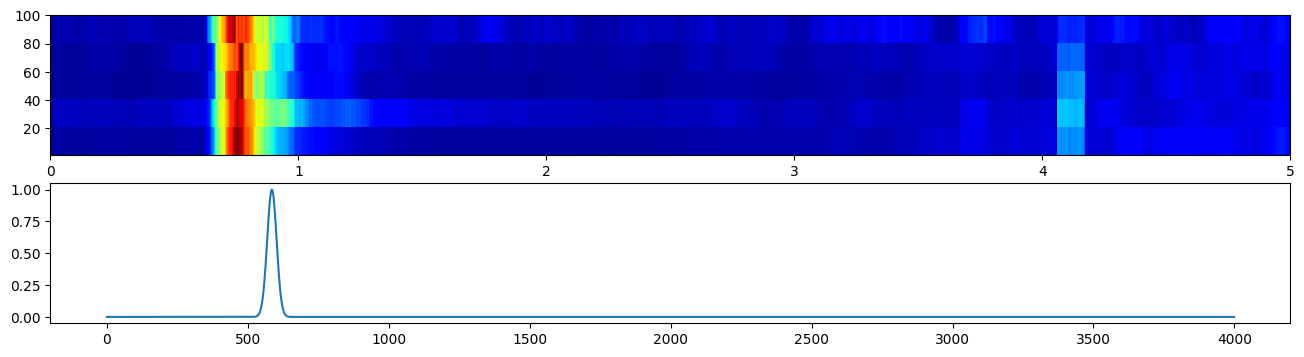

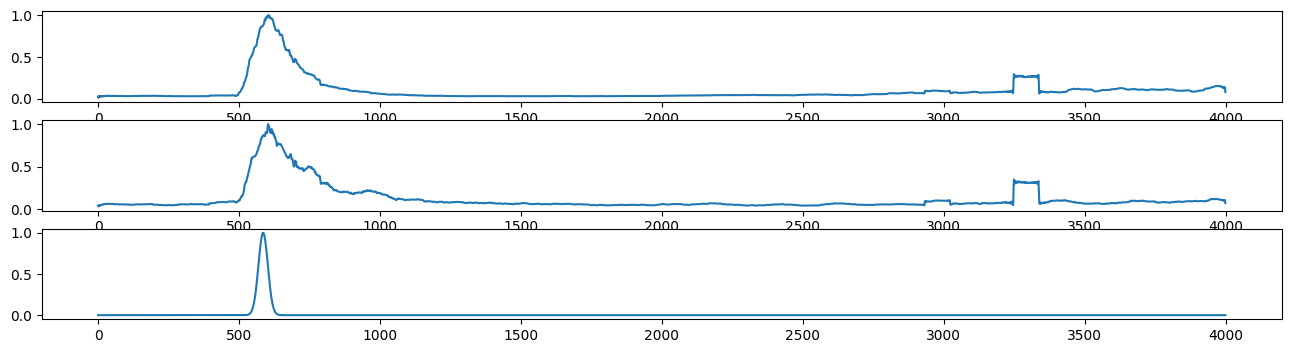

In [7]:
# Define base directory for data.
base_dir_mars = 'data/mars/training'

# Construct paths in a cross-platform way, compatible with Windows and Linux.
catalogy_path_mars = os.path.join(base_dir_mars, 'catalogs', 'Mars_InSight_training_catalog_final.csv')
data_folder_mars = os.path.join(base_dir_mars, 'data')

# Read the catalog file which contains metadata about the dataset (e.g., file names, labels, etc.).
# catalogy holds the times of the seismic events.
# Each line of catalogy has a filename that has velocity by time, and where the seismic event is in the sequence.
catalogy_mars = pd.read_csv(catalogy_path_mars)
indexs_mars = catalogy_mars.index  # Get the indices of the catalog entries

# Initialize a dictionary to hold validation data.
validation_data_mars = {
    "data": [],
    "label": []
}

# Function to process a file given its index in the catalog.
def process_file_mars(idx):
    # Get the filename and arrival time from the catalog.
    fileName = catalogy_mars.at[idx, 'filename'].replace(".csv", "") + '.mseed'
    arrival_time = catalogy_mars.at[idx, 'time_rel(sec)']

    # Check if the file exists.
    if not os.path.exists(os.path.join(data_folder_mars, fileName)):
        return None, None

    # Read the seismic data file and preprocess it.
    stream = obspy.read(os.path.join(data_folder_mars, fileName))
    data = stream[0].data
    time = stream[0].times()
    fs = stream[0].stats.sampling_rate

    # Find the index of the arrival time.
    arrival_idx = np.where(time >= arrival_time)[0][0]

    # Define the window size for processing.
    window_size_sec = 80
    window_size = int(window_size_sec * fs)

    # Apply a bandpass filter to the data.
    data = butter_bandpass_filter(data, 2, 8, fs, 6)

    # Perform ensemble empirical mode decomposition (EEMD) on the data.
    imfs = emd.sift.ensemble_sift(data, max_imfs=5)
    stride = window_size // 48
    input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride, :, :]
    input = np.sum(input, axis=-1)

    # Initialize the output array.
    output = np.zeros((data.shape[0], ))

    # Find the index for the arrival time adjusted by the window size.
    arrival_idx = np.where(time - window_size_sec / 4 >= arrival_time)[0][0]
    sigma = window_size / 8 * 1.5
    gaussian_window_size = int(window_size * 1.5)
    if gaussian_window_size % 2 == 1: gaussian_window_size += 1
    gaussian_window = sg.windows.gaussian(gaussian_window_size, std=sigma)
    left_idx = arrival_idx - (gaussian_window_size // 2)
    right_idx = arrival_idx + (gaussian_window_size // 2)

    # Adjust the indices if they are out of bounds.
    if left_idx < 0:
        left_idx = 0
    if right_idx > len(output):
        right_idx = len(output)

    # Apply the Gaussian window to the output array.
    output[left_idx:right_idx] = gaussian_window[:right_idx - left_idx]

    # Resample the input and output arrays.
    input = sg.resample(input, 4000, axis=0)
    output = sg.resample(output, 4000)

    # Normalize the input data.
    input_maxs = np.max(input, axis=0)
    input = input / input_maxs

    # Ensure the input has at least 5 columns.
    while input.shape[1] < 5:
        input = np.concatenate([input, np.zeros((input.shape[0], 1)) + 0.001], axis=1)

    return input, output

# Randomly split the indices into training and testing sets.
# There are 76 files in the catalog, we are using, in this case, 66 for training and 10 for validation.
indexs_validation_mars = [0, 1]

# Uncomment the following code to process all training indices in parallel using multiple threads:
with ThreadPoolExecutor(max_workers=os.cpu_count() - 2) as executor:
    results_mars = list(tqdm(executor.map(process_file_mars, indexs_validation_mars), total=len(indexs_validation_mars)))

# Append the processed data to the validation_data_mars dictionary.
for r in results_mars:
    if r[0] is None:
        print('skip')
        continue
    validation_data_mars['data'].append(r[0])
    validation_data_mars['label'].append(r[1])

# Get the first result for visualization.
inp, out = results_mars[0]
print(inp.shape)

# Plot the input and output data.
fig, axs = plt.subplots(2, 1, figsize=(16, 4))
axs[0].imshow(inp.T, aspect='auto', cmap='jet', interpolation='nearest', origin='lower', extent=[0, inp.shape[1], 1, 100], vmin=0, vmax=inp.max())
axs[1].plot(out)

# Plot individual components of the input data.
fig, axs = plt.subplots(3, 1, figsize=(16, 4))
axs[0].plot(inp[:, 0])
axs[1].plot(inp[:, 1])
axs[2].plot(out)

### ORGANIZING DATA FOR TRAINING ###

In [8]:
# Convert the lists to numpy arrays:
# Moon:
training_data['data'] = np.array(training_data['data'])
training_data['label'] = np.array(training_data['label'])

validation_data['data'] = np.array(validation_data['data'])
validation_data['label'] = np.array(validation_data['label'])

# Mars:
validation_data_mars['data'] = np.array(validation_data_mars['data'])
validation_data_mars['label'] = np.array(validation_data_mars['label'])


# Transpose the data to have the correct shape:
# Moon:
X_train = training_data['data'].transpose(0, 2, 1)
Y_train = training_data['label'][:,np.newaxis,:]

X_eval = validation_data['data'].transpose(0, 2, 1)
Y_eval = validation_data['label'][:,np.newaxis,:]

# Mars:
X_eval_mars = validation_data_mars['data'].transpose(0, 2, 1)
Y_eval_mars = validation_data_mars['label'][:,np.newaxis,:]

## TRAINING ##

### SETTING UP FOR TRAINING: ###

In [9]:
# Set the device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
if device == 'cuda':
    print("Training will run on GPU.")
else:
    print("Training will run on CPU.")

# ============== Convert numpy arrays to tensors and move to GPU ==============

# Moon:
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32).to(device)
Y_eval_tensor = torch.tensor(Y_eval, dtype=torch.float32).to(device)

print(f'X_tensor shape: {X_tensor.shape}')
print(f'Y_tensor shape: {Y_tensor.shape}')

print(f'\nX_eval_tensor shape: {X_eval_tensor.shape}')
print(f'Y_eval_tensor shape: {Y_eval_tensor.shape}')

# Mars:
X_eval_mars_tensor = torch.tensor(X_eval_mars, dtype=torch.float32).to(device)
Y_eval_mars_tensor = torch.tensor(Y_eval_mars, dtype=torch.float32).to(device)

print(f'\nX_eval_mars_tensor shape: {X_eval_mars_tensor.shape}')
print(f'Y_eval_mars_tensor shape: {Y_eval_mars_tensor.shape}')

# ================================== DONE ====================================


# ================= Create a DataLoaders with the datasets ===================

generator = torch.Generator(device=device)  # Ensure DataLoader uses GPU generator

# Moon:
dataset = TensorDataset(X_tensor, Y_tensor)
eval_dataset = TensorDataset(X_eval_tensor, Y_eval_tensor)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, generator=generator)
eval_loader = DataLoader(eval_dataset, batch_size=2, shuffle=False, generator=generator)

# Mars:
eval_mars_dataset = TensorDataset(X_eval_mars_tensor, Y_eval_mars_tensor)
eval_loader_mars = DataLoader(eval_mars_dataset, batch_size=2, shuffle=False, generator=generator)

# ============================ DataLoaders created ============================

# ============================ Model and training setup ========================

# Initialize the model and move to GPU
model = model = UNET(5,128,7,3).to(device)

# Set optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adam optimizer with weight decay

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8, min_lr=1e-8) # Using ReduceLROnPlateau schedule

criterion = nn.MSELoss()  # Mean Squared Error Loss for binary classification

# Early stopping setup
patience = 100  # Number of epochs to wait before stopping if no improvement
min_delta = 0.0001  # Minimum change in loss to qualify as an improvement
best_loss = float('inf')  # Initialize best loss with a large value
patience_counter = 0  # Counter for early stopping

# ============================ Setup finished ==================================

Training will run on GPU.
X_tensor shape: torch.Size([62, 5, 4000])
Y_tensor shape: torch.Size([62, 1, 4000])

X_eval_tensor shape: torch.Size([13, 5, 4000])
Y_eval_tensor shape: torch.Size([13, 1, 4000])

X_eval_mars_tensor shape: torch.Size([2, 5, 4000])
Y_eval_mars_tensor shape: torch.Size([2, 1, 4000])


### TRAINING! ###

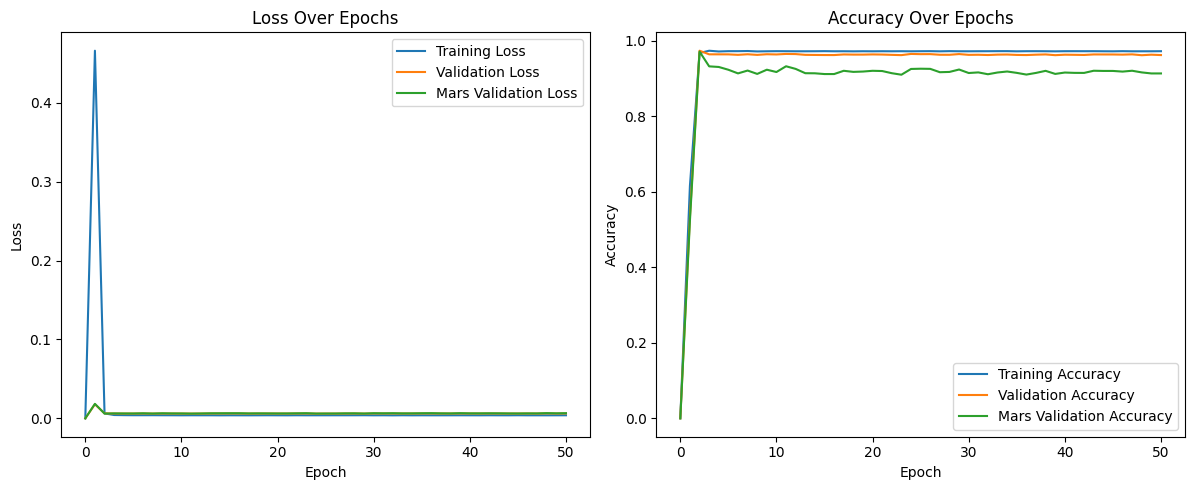

Epoch 50/50
Moon training Loss: 0.0039, Moon training Accuracy: 0.9720
Moon validation Loss: 0.0062, Moon validation Accuracy: 0.9618
Mars validation Loss: 0.0065, Mars validation Accuracy: 0.9131


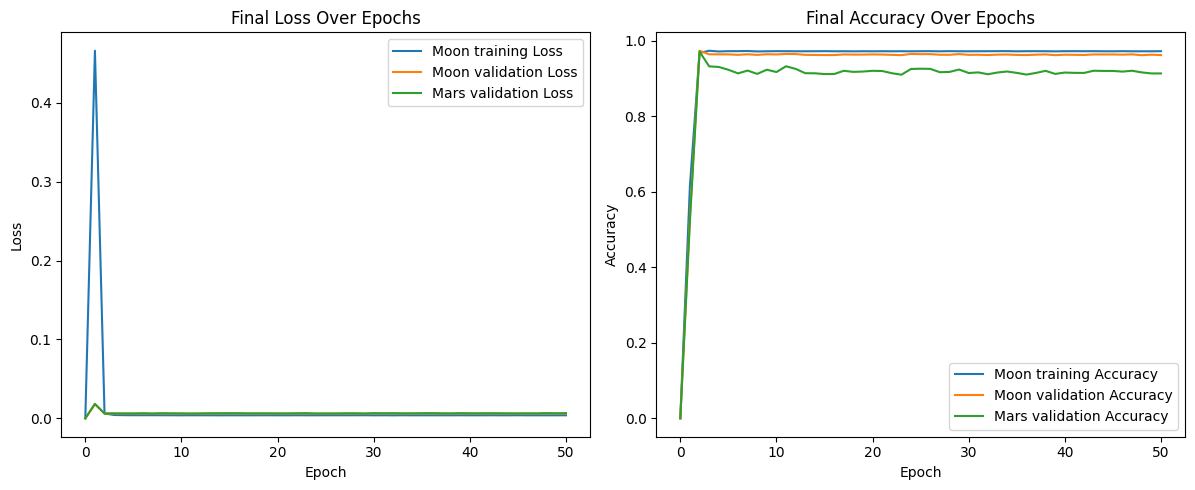

Results:
      - Moon training Loss: 0.0039
      - Moon training Accuracy: 0.9720
                -
      - Moon validation Loss: 0.0062
      - Moon Validation Accuracy: 0.9618
                -
      - Mars validation Loss: 0.0065
      - Mars validation Accuracy: 0.9131


In [10]:
# Number of epochs to train
num_epochs = 50

# Lists to store metrics
train_losses = [0]
train_accuracies = [0]
val_losses = [0]
val_accuracies = [0]
val_losses_mars = [0]
val_accuracies_mars = [0]

# Training loop
for epoch in range(num_epochs):

    # Set the model to training mode
    model.train()

    # Initializing metrics for the epoch:
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate through training data
    for inputs, labels in train_loader:

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # MSE Loss:
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update learning rate
        scheduler.step(loss)

        # Track running loss
        running_loss += loss.item()

        # Calculate accuracy
        correct_predictions += torch.sum(torch.abs(outputs - labels) < 0.1).item()
        total_predictions += torch.numel(outputs)

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate the model on validation set for each epoch
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass
            eval_loss = criterion(outputs, labels)  # Calculate loss
            val_running_loss += eval_loss.item()

            # Calculate accuracy
            val_correct_predictions += torch.sum(torch.abs(outputs - labels) < 0.1).item()
            val_total_predictions += torch.numel(outputs)

    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(eval_loader)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Evaluate the model on Mars validation set for each epoch
    val_running_loss_mars = 0.0
    val_correct_predictions_mars = 0
    val_total_predictions_mars = 0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in eval_loader_mars:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass
            eval_loss = criterion(outputs, labels)  # Calculate loss
            val_running_loss_mars += eval_loss.item()

            # Calculate accuracy
            val_correct_predictions_mars += torch.sum(torch.abs(outputs - labels) < 0.1).item()
            val_total_predictions_mars += torch.numel(outputs)

    # Calculate average Mars validation loss and accuracy for the epoch
    val_epoch_loss_mars = val_running_loss_mars / len(eval_loader_mars)
    val_epoch_accuracy_mars = val_correct_predictions_mars / val_total_predictions_mars
    val_losses_mars.append(val_epoch_loss_mars)
    val_accuracies_mars.append(val_epoch_accuracy_mars)

    # Clear output and plot
    clear_output(wait=True)

    # Plot the metrics
    plt.figure(figsize=(18, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(val_losses_mars, label='Mars Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(val_accuracies_mars, label='Mars Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print current metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Moon training Loss: {epoch_loss:.4f}, Moon training Accuracy: {epoch_accuracy:.4f}")
    print(f"Moon validation Loss: {val_epoch_loss:.4f}, Moon validation Accuracy: {val_epoch_accuracy:.4f}")
    print(f"Mars validation Loss: {val_epoch_loss_mars:.4f}, Mars validation Accuracy: {val_epoch_accuracy_mars:.4f}")

# After training completes
# Plot the final metrics
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Moon training Loss')
plt.plot(val_losses, label='Moon validation Loss')
plt.plot(val_losses_mars, label='Mars validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Moon training Accuracy')
plt.plot(val_accuracies, label='Moon validation Accuracy')
plt.plot(val_accuracies_mars, label='Mars validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Final Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("""Results:
      - Moon training Loss: {:.4f}
      - Moon training Accuracy: {:.4f}
                -
      - Moon validation Loss: {:.4f}
      - Moon Validation Accuracy: {:.4f}
                -
      - Mars validation Loss: {:.4f}
      - Mars validation Accuracy: {:.4f}""".format(
          epoch_loss, epoch_accuracy, val_epoch_loss, val_epoch_accuracy, val_epoch_loss_mars, val_epoch_accuracy_mars))

# Save the model
torch.save(model.state_dict(), 'model.pth')


## Testing the ANN

In [11]:
# Load Lunar Test Files
import os
folder = rf'data\lunar\test\data'
# folder = rf'data\lunar\training\data'
curDir = os.getcwd()
dirs = os.listdir(folder)
files_path = []
for dir in dirs:
    files = os.listdir(os.path.join(folder, dir))
    for file in files:
        if file.endswith('.mseed'):
            files_path.append(os.path.join(curDir, folder, dir, file))

In [13]:

def lunar_seismic_prediction(num, save_csv=False, save_plot=True):
    try:
        
        # Input Signal
        file = files_path[num]
        stream = obspy.read(os.path.join(file))
        data = stream[0].data
        time = stream[0].times()
        fs = stream[0].stats.sampling_rate

        original_data = data.copy()

        # Pre-Processing
        window_size_sec = 30 * 60
        window_size = int(window_size_sec * fs)
        data = butter_bandpass_filter(data, 0.4, 1, fs, 6)
        imfs = emd.sift.ensemble_sift(data, max_imfs=5)
        stride = window_size//48
        input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride,:,:]
        input = np.sum(input, axis=-1)
        input = sg.resample(input, 4000, axis=0)
        while input.shape[1] < 5:
            input = np.concatenate([input, np.zeros((input.shape[0], 1)) + 0.001], axis=1)
        input_maxs = np.max(input, axis=0)
        input = input/input_maxs
        input = input.T

        # Model Prediction
        input_tensor = torch.tensor(input[np.newaxis, :, :], dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            y_pred = model(input_tensor).cpu().numpy().reshape(-1,)

        # Post-Processing
        results = np.where(y_pred > 0.25, 1, 0)
        found = 0
        for i in range(len(results)):
            if found == 1:
                if any(results[i:i+10] == 1):
                    results[i] = 0
                else:
                    found = 0
            if results[i] == 1 and found == 0:
                found = 1

        # Actual Time Detected
        idxs = np.where(results == 1)[0]
        actual_time_detected = []
        for idx in idxs: 
            _pos = idx/4000 * time[-1] # Real position in input time scale
            actual_time_detected.append(_pos)


        # Catalog Info
        filename = file.split('\\')[-1].replace('.mseed', '')
        time_abs = stream[0].stats.starttime.strftime(r'%Y-%m-%dT%H:%M:%S.%f')
        if len(actual_time_detected) == 0:
            time_rel = -1
        else:
            time_rel = actual_time_detected[0]
        evid = filename.split('_')[-1].replace('.mseed', '')
        catalog_lunar['filename'].append(filename)
        catalog_lunar[r'time_abs(%Y-%m-%dT%H:%M:%S.%f)'].append(time_abs)
        catalog_lunar['time_rel(sec)'].append(time_rel)
        catalog_lunar['evid'].append(evid)

        if save_csv: # Csv Update
            file_csv = files_path[num].replace('.mseed', '.csv')
            data_csv = pd.read_csv(file_csv)
            csv_time = data_csv['time_rel(sec)'].to_numpy()
            prediction_csv = []
            for pred_time in actual_time_detected:
                prediction_csv.append(np.abs(csv_time - pred_time) < window_size_sec/16)
            prediction_csv = np.any(prediction_csv, axis=0)
            data_csv['prediction'] = prediction_csv.astype(int)
            data_csv.to_csv(rf'lunar_predictions\data_csv\{filename}.csv', index=False)

        if save_plot: # Plot the detected wave
            figs, axs = plt.subplots(1, 1, figsize=(12, 4))
            axs.plot(time, original_data,'b')
            axs.set_xlabel('Time (s)')
            axs.set_ylabel('Velocity (m/s)')
            axs.set_title(f'Prediction - {filename}')
            for _time in actual_time_detected:
                axs.axvline(_time, color='r', linestyle='--', label='Rel. Arrival')
            axs.legend()
            figs.savefig(fr'lunar_predictions\plot\{filename}.png', dpi=300, bbox_inches='tight')
            figs.clf()

    except Exception as e:
        print(f'Error in {file} - {e}')
    return 0

catalog_lunar = {
    'filename': [],
    r'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [],
    'time_rel(sec)': [],
    'evid': [],
}

if not os.path.exists(r'lunar_predictions'):
    os.makedirs(r'lunar_predictions')
if not os.path.exists(r'lunar_predictions\data_csv'):
    os.makedirs(r'lunar_predictions\data_csv')
if not os.path.exists(r'lunar_predictions\plot'):
    os.makedirs(r'lunar_predictions\plot')

# for i in tqdm(range(len(files_path))):
#     lunar_seismic_prediction(i)

# Parallel Processing
indexs = range(len(files_path))
with ThreadPoolExecutor(max_workers=4) as executor:
    results ==  list(tqdm(executor.map(lunar_seismic_prediction, indexs), total=len(indexs)))

catalog_lunar_df = pd.DataFrame(catalog_lunar)
catalog_lunar_df.to_csv(r'lunar_predictions\catalog.csv', index=False)
clear_output(wait=False)

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [14]:
# Load Mars Test Files
import os
folder = rf'data\mars\test'
curDir = os.getcwd()
dirs = os.listdir(folder)
files_path = []
for dir in dirs:
    files = os.listdir(os.path.join(folder, dir))
    for file in files:
        if file.endswith('.mseed'):
            files_path.append(os.path.join(curDir, folder, dir, file))

In [17]:
def butter_bandstop_filter(data:np.array, lowcut:float, highcut:float, fs:float, order:int):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sg.butter(order, [low, high], btype='bandstop', analog=False)
    y = sg.filtfilt(b, a, data)
    return y



def mars_seismic_prediction(num, save_csv=False, save_plot=True):
    try:
        # Input Signal
        file = files_path[num]
        stream = obspy.read(os.path.join(file))
        data = stream[0].data
        time = stream[0].times()
        fs = stream[0].stats.sampling_rate
        original_data = data.copy()

        # Pre-Processing
        data = butter_bandpass_filter(data, 0.5, 3, fs, 6)

        imfs = emd.sift.ensemble_sift(data, max_imfs=5)
        window_size_sec = 80
        window_size = int(window_size_sec * fs)
        stride = window_size//48
        input = np.lib.stride_tricks.sliding_window_view(imfs**2, window_shape=window_size, axis=0)[::stride,:,:]
        input = np.sum(input, axis=-1)
        input = sg.resample(input, 4000, axis=0)
        input_maxs = np.max(input, axis=0)
        input = input/input_maxs
        input = input.T

        # Model Prediction
        input_tensor = torch.tensor(input[np.newaxis, :, :], dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            y_pred = model(input_tensor).cpu().numpy().reshape(-1,)
        results = np.where(y_pred > 0.3, 1, 0)
        found = 0
        for i in range(len(results)):
            if found == 1:
                if any(results[i:i+50] == 1):
                    results[i] = 0
                else:
                    found = 0
            if results[i] == 1 and found == 0:
                found = 1

        # Actual Time Detected
        idxs = np.where(results == 1)[0]
        actual_time_detected = []
        for idx in idxs: 
            _pos = idx/4000 * time[-1] # Real position in input time scale
            actual_time_detected.append(_pos)

        # Catalog Info
        filename = file.split('\\')[-1].replace('.mseed', '')
        time_abs = stream[0].stats.starttime.strftime(r'%Y-%m-%dT%H:%M:%S.%f')
        if len(actual_time_detected) == 0:
            time_rel = -1
        else:
            time_rel = actual_time_detected[0]
        evid = filename.split('_')[-1].replace('.mseed', '')
        catalog_mars['filename'].append(filename)
        catalog_mars[r'time_abs(%Y-%m-%dT%H:%M:%S.%f)'].append(time_abs)
        catalog_mars['time_rel(sec)'].append(time_rel)
        catalog_mars['evid'].append(evid)

        if save_csv: # Csv Update
            file_csv = files_path[num].replace('.mseed', '.csv')
            data_csv = pd.read_csv(file_csv)
            csv_time = data_csv['time_rel(sec)'].to_numpy()
            prediction_csv = []
            for pred_time in actual_time_detected:
                prediction_csv.append(np.abs(csv_time - pred_time) < window_size_sec/16)
            prediction_csv = np.any(prediction_csv, axis=0)
            data_csv['prediction'] = prediction_csv.astype(int)
            data_csv.to_csv(rf'mars_predictions\data_csv\{filename}.csv', index=False)

        if save_plot: # Plot the detected wave
            figs, axs = plt.subplots(1, 1, figsize=(12, 4))
            axs.plot(time, original_data,'b')
            axs.set_xlabel('Time (s)')
            axs.set_ylabel('Velocity (m/s)')
            axs.set_title(f'Prediction - {filename}')
            for _time in actual_time_detected:
                axs.axvline(_time, color='r', linestyle='--', label='Rel. Arrival')
            axs.legend()
            figs.savefig(fr'mars_predictions\plot\{filename}.png', dpi=300, bbox_inches='tight')
            figs.clf()

    except Exception as e:
        print(f'Error in {file} - {e}')
    return 0

catalog_mars = {
    'filename': [],
    r'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [],
    'time_rel(sec)': [],
    'evid': [],
}

if not os.path.exists(r'mars_predictions'):
    os.makedirs(r'mars_predictions')
if not os.path.exists(r'mars_predictions\data_csv'):
    os.makedirs(r'mars_predictions\data_csv')
if not os.path.exists(r'mars_predictions\plot'):
    os.makedirs(r'mars_predictions\plot')

for i in tqdm(range(len(files_path))):
    mars_seismic_prediction(i)

catalog_mars_df = pd.DataFrame(catalog_mars)
catalog_mars_df.to_csv(r'mars_predictions\catalog.csv', index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>